# Forecasting revenue of a product with Monte-Carlo simulation

Being able to see the future would be a great superpower (or so one would think). Luckily, it is already possible to _model_ the future using Python to gain insights into a number of problems from many different areas. In marketing, being able to model how successful a new product will be, would be of great use. In this post, I will take a look at how we can model the future revenue of a product by making certain assumptions and running a Monte Carlo Markov Chain simulation.

## What are Monte Carlo methods?

Wikipedia tells us that: 
> Monte Carlo methods (or Monte Carlo experiments) are a broad class of computational algorithms that rely on repeated random sampling to obtain numerical results. Their essential idea is using randomness to solve problems that might be deterministic in principle.

In simple terms, we define a number of rules about how a system will behave based on assumptions, and then use random samplings of these conditions over and over and measure the results. We can then look at the results altogether to gain insights into our model.

Let's see this in practice!

In [42]:
import numpy as np
from pylab import triangular, zeros, percentile
from scipy.stats import binom
import pandas as pd
import seaborn as sns
sns.set_palette('coolwarm')
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
%matplotlib inline

## Define the initial assumptions

What assumptions can we safely make regarding our new product? For example, what is the estimated market size that we want to work with and what is the estimated price that we can expect. We also define the num_timesteps, the number of years for which we want to make the calculations.

In [43]:
# initial market size assumption (total number of potential users)
marketsize_min = 5000
marketsize_mode = 12000
marketsize_max = 15000

marketshare_init = triangular(.003, .005, .01) # min, mode, max
# initial percentage of users that use the product

price_min=500 # minimum product price
price_mode=1000 # mode product price
price_max=1500 # maximum product price

num_timesteps=10 # number of years for the simulation
num_simulations=1024 # number of simulations per year
perc_selection = [5, 25, 50, 75, 95] # percentiles to visualize in plots

## Define the functions to calculate market share and revenue of a product

These are the functions used to get the data points by random sampling. Each time we run each function, the variables are randomly defined from a range and a result is obtained, e.g. a market share or a revenue amount.

In [44]:
def calc_marketshare(marketsize, marketshare):
    '''
    Calculates product market share for a given year as percentage of users
    that use the product compared to total number of users
    
    Arguments:
    marketsize : total market size as number of potential users
    marketshare: observed/assumed percentage of users that use the product
    '''    
    share = binom.rvs(marketsize, marketshare, size=1) / marketsize    
    return share


def calc_revenue(marketsize, marketshare):
    '''
    Calculates the revenue development over a number of years
    
    Arguments:
    marketsize: total market size as number of potential users
    marketshare : observed/assumed percentarge of users that use the product
    '''    
    product_price = triangular(price_min, price_mode, price_max)
    volume = marketsize*marketshare
    revenue = product_price * volume
    return revenue

Additionally, in case that a distribution is not included in the standard statistical modules of Python, we can custom write them. For example, we can define functions to return logistic and sigmoid distributions.

In [45]:
def logist(x, loc, scale, factor):
    '''
    Logistic distribution
    Args:
    x : variable in x-axis, e.g. time
    loc : the mean of the distribution, maximum probability
    scale : steepness of the curve, higher -> steeper
    factor : multiplies to obtain higher probabilities overall
    '''
    return factor*np.exp((loc-x)/scale)/(scale*(1+np.exp((loc-x)/scale))**2)

def sigmoid(x):
    L, q, loc = 10, 1, 3
    return L/(1+np.exp(-q*(x-loc)))

Why do we need this logistic distribution? For example, if we want to take into account the market growth in the next ten years, we could simply assume it will be 1% or 2% or 10% and keep it constant. However, we have Python on our side and can rather model this growth in a semi-random way. We assume that the market growth is more likely to be lower (between 0 and 4%) but we want to also consider the lower probability cases in which the growth could be higher, e.g. 8%.

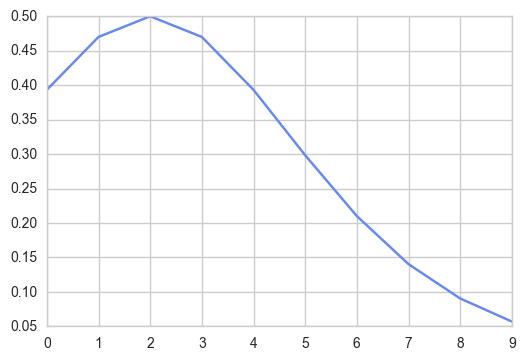

In [46]:
def logist_test(x, loc, scale):
    loc, scale = 2, 2
    return 4*np.exp((loc-x)/scale)/(scale*(1+np.exp((loc-x)/scale))**2)

plt.plot(logist_test(x, loc, scale))
plt.show()

## Data collection and simulation

Now that we have all assumptions and "rules" in place, let's get some data points.

First let's create some empty matrixes where we will put the data later.

In [47]:
u = zeros((num_simulations,), dtype=float) 
# temporary market size matrix as number of potential users
s = zeros((num_simulations,), dtype=float) # temporary market share matrix
r = zeros((num_simulations,), dtype=float) # temporary revenue matrix

rev = zeros((num_timesteps, num_simulations), dtype=float) 
# revenue data collection by year
percentiles_rev = zeros((num_timesteps,len(perc_selection)), dtype=float) 
# percentiles_rev data collection by year

usr = zeros((num_timesteps, num_simulations), dtype=float) 
# users data collection by year
percentiles_usr = zeros((num_timesteps,len(perc_selection)), dtype=float) 
# percentiles for total users

sha = zeros((num_timesteps, num_simulations), dtype=float) 
# market share data collection by year
percentiles_sha = zeros((num_timesteps,len(perc_selection)), dtype=float) 
# percentiles for market share

Now we can run the simulations to get our data points for the next 10 years. The results are captured in the pre-created matrices.

In [48]:
for t in range(0, num_timesteps):
    
    if t==0: # First year starting with initial assumptions
        for k in range(num_simulations):
            u[k] = triangular(marketsize_min,marketsize_mode,marketsize_max) 
            # triangular distribution of current number of potential users
            s[k] = calc_marketshare(u[k], marketshare_init) 
            # market share for product
            r[k] = calc_revenue(u[k], s[k]) # revenue
        # store values in first row of matrices:
        rev[t,:] += r
        usr[t,:] += u
        sha[t,:] = s
        #percentiles of the complete revenue row at time t        
        percentiles_rev[t,:] = percentile(rev[t,:], perc_selection)
        percentiles_usr[t,:] = percentile(usr[t,:], perc_selection)
        percentiles_sha[t,:] = percentile(sha[t,:], perc_selection)
        
    else: # Following years starting with the previous year's data
        for k in range(num_simulations):
            # estimate how much the market has grown:
            loc = triangular(1, 2, 4)
            scale = triangular(1, 2, 3)
            factor = 3
            marketgrowth = logist(t, loc, scale, factor)
            u[k] += u[k] * marketgrowth # apply market growth
            s[k] = calc_marketshare(u[k], s[k]) + logist(t, 4, 5, 1) 
            # apply market share increase
            r[k] = calc_revenue(u[k], s[k]) # calculate revenue
        # store values in following rows of matrices
        rev[t,:] = rev[t-1,:] + r
        usr[t,:] += u
        sha[t,:] = s
        #percentiles of the complete revenue row at time t
        percentiles_rev[t,:] = percentile(rev[t,:], perc_selection)
        percentiles_usr[t,:] = percentile(usr[t,:], perc_selection)
        percentiles_sha[t,:] = percentile(sha[t,:], perc_selection)

## Revenue simulation plots

Having captured all our data, we can now plot it to see how the variable of interest, in this case the revenue of the new product, develops in the next 10 years.

First we print the percentiles to get the numeric data:

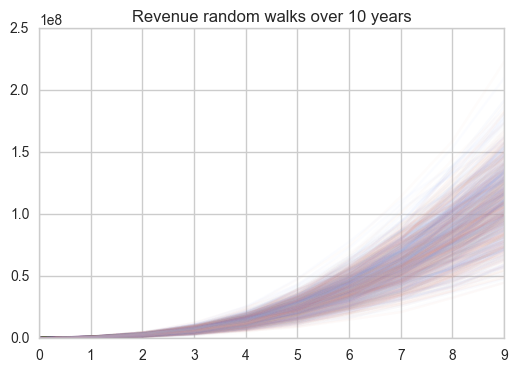

In [49]:
# Print the percentiles of revenue
df = pd.DataFrame(percentiles_rev, columns=['5%','25%','50%','75%','95%'])
df

Now we can plot these percentiles of revenue in an aggregated form.

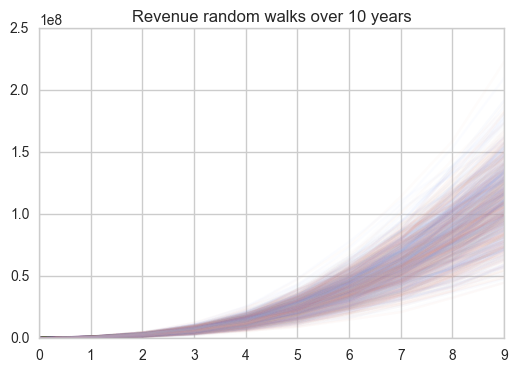

In [50]:
# Plot the percentiles of revenue
x = np.arange(0,10)
df.plot(kind='line', color='black', linewidth=0.2)
plt.fill_between(x,df['25%'].values,df['75%'].values, color='grey', alpha=0.6)
plt.fill_between(x,df['5%'].values,df['95%'].values, color='grey', alpha=0.4)
plt.title("Revenue percentiles over %s years" %num_timesteps)
plt.show()

We can also plot the individual "random walks" of the simulation just for fun.

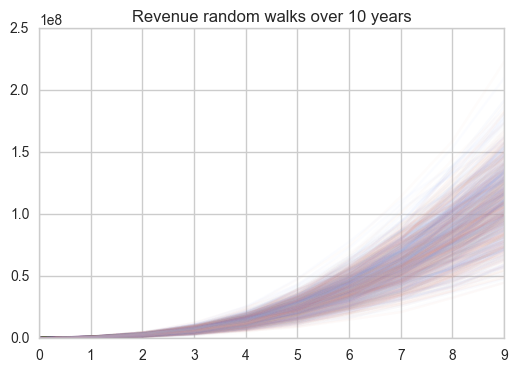

In [51]:
# Plot the random walks for revenue
df2=pd.DataFrame(rev)
df2.plot(kind='line', legend=False, alpha=.03)
plt.title("Revenue random walks over %s years" %num_timesteps)
plt.show()

## Market share simulation plots

Similarly, let's plot our simulation results for the market share calculations

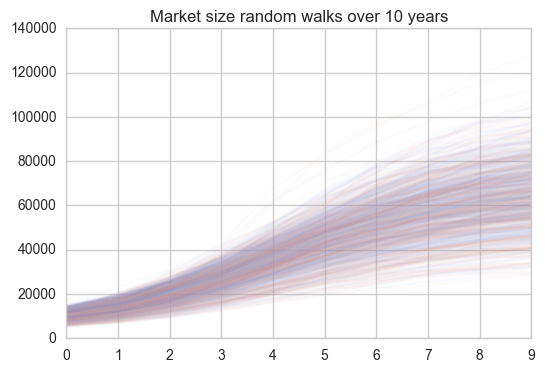

In [52]:
# Print the percentiles of market size
df_usr = pd.DataFrame(percentiles_usr, columns=['5%','25%','50%','75%','95%'])
#print(df)

# Plot the percentiles market size
x = np.arange(0,10)
df_usr.plot(kind='line', color='w')
plt.fill_between(x,df_usr['25%'].values,df_usr['75%'].values, color='grey', alpha=0.6)
plt.fill_between(x,df_usr['5%'].values,df_usr['95%'].values, color='grey', alpha=0.4)
plt.title("Market size percentiles over %s years" %num_timesteps)
plt.show()

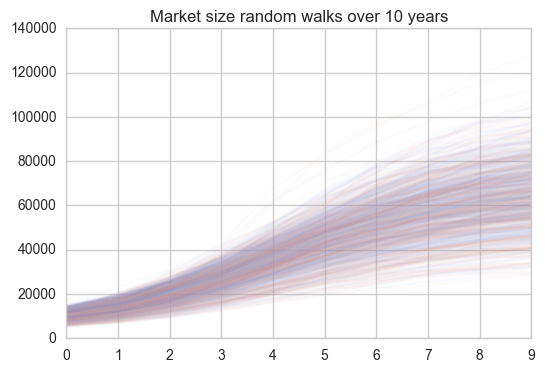

In [53]:
# Plot the random walks for market size
df2=pd.DataFrame(usr)
df2.plot(kind='line', legend=False, alpha=.03)
plt.title("Market size random walks over %s years" %num_timesteps)
plt.show()

## Product revenue and market size distribution

Finally, we can visualize how the revenue is distributed in our simulation for a particular year using histograms. For example, let's plot the distribution of revenue:

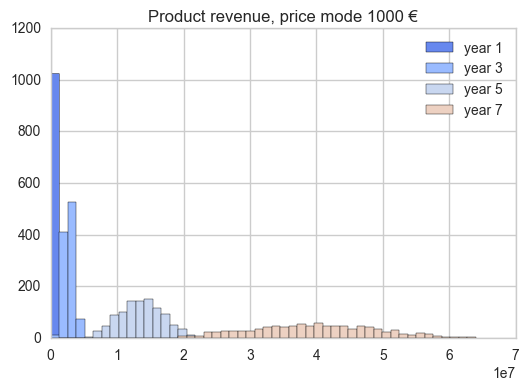

In [54]:
ax1 = plt.subplot(111)
ax1
plt.title("Product revenue, price mode %s €" %price_mode)
plt.hist(rev[0], bins=50, range=(0, r.max()), label='year 1')
plt.hist(rev[2], bins=50, range=(0, r.max()), label='year 3')
plt.hist(rev[4], bins=50, range=(0, r.max()), label='year 5')#axis([0,width,0,height])
plt.hist(rev[6], bins=50, range=(0, r.max()), label='year 7')
plt.legend()
plt.show()

Of course, the farther in the future our model, the wider the distribution, as our model gets more and more uncertain.

We can do the same with the market size distribution:

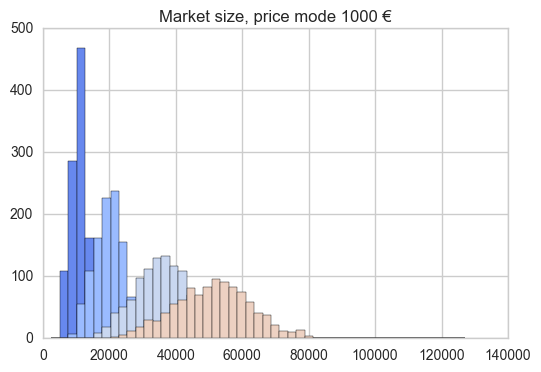

In [54]:
ax2 = plt.subplot(111)
ax2
plt.title("Market size, price mode %s €" %price_mode)
#hist(c, bins=50, range=(0, c.max()), )
plt.hist(usr[0], bins=50, range=(0, u.max()), label='year 1')
plt.hist(usr[2], bins=50, range=(0, u.max()), label='year 3')
plt.hist(usr[4], bins=50, range=(0, u.max()), label='year 5')
plt.hist(usr[6], bins=50, range=(0, u.max()), label='year 7')
plt.show()

# Final remarks

In this post, we saw how we can use Python to model a simple Monte Carlo simulation and how we can plot these results to look at forecasting from a different perspective.